In [127]:
# the usual boilerplate stuff
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
from scipy.stats import norm as gaussian
dum = plt.rcParams['text.usetex'] = True  # can use latex in figures
np.set_printoptions(precision=3)

# PART THREE: we use a GP to do really efficient optimization


In [128]:
N=101
X = np.linspace(-5,5,N)

In [129]:
# the KERNEL is just a function of two points in x-space. 
# These really ought to each be vectors, but for simplicity we're playing around
# with a 1-dimensional x-space here so they're just scalars :(   [easily fixed]
def kernel(x1,x2,params):
    # x1, x2 should be scalars
    
    d = np.abs(x1-x2)
    
    prior_pairwise_covar = params['theta_peak'] * np.exp(-(d/params['theta_width'])**params['exponent'])
    if x1==x2:
        prior_pairwise_covar += params['theta_noise'] 
    return prior_pairwise_covar

#-------------------------------------------------------------------

# this isn't very "numpy" style, but oh well!
def makeCovMatrix(X,params):
    N = len(X)
    cv = np.zeros((N,N),dtype=float)
    for i,x1 in enumerate(X):
        for j,x2 in enumerate(X):
            cv[i,j] = kernel(x1,x2,params)
    return cv

def prediction(x_query, X, y, params):
    n = len(X)
    Kvec = np.zeros(n)
    for k in range(n):
        Kvec[k] = kernel(X[k], x_query, params)

    tmp = np.dot(Kvec,inv_cov_matrix) # used in both mean and var.
    tmp = np.atleast_2d(tmp)
    mu = np.dot(tmp,np.atleast_2d(y).T)[0,0]  # should be a 1x1 "matrix"!
    var = params['theta_peak'] - np.dot(tmp,Kvec)[0]
    var = max(var,0.0)
    return(mu, var)




# Gaussian Process prediction in practice

In [130]:
# Short summary: if the data is....
X_data = [-2.,-3,-2.5]
def true_surface(x):
    y = np.sin(x)
    return y
y_data = true_surface(X_data) #[.4,.2,.3]

# and parameters are
params = {'theta_width': 1.5, 'theta_peak': 1.0, 'theta_noise': 0.1, 'exponent': 2.0}
# YOU CAN PLAY WITH ANY OF THOSE NUMBERS: PLEASE DO.
# THEY ARE ASSUMPTIONS! Could be wrong for a given data set.
#
# theta_width controls how kernel fades with x distance
# theta_peak controls the overall vertical (meaning y) "scale" of the variations
# theta_noise is std dev of the measurement noise
# Finally there's the exponent (try 1.0, try 2.0, or something in between)


# just the x space for plotting...
xs = np.linspace(-5.0,5.0,101)

# and need to define an infill criterion!
def infill_function(y_means, y_stds, y_best_so_far):
    # dumb one
    val = y_means + y_stds - y_best_so_far
    # better one
    standardized_best = (y_best_so_far - y_means)/y_stds
    val = 1-gaussian.cdf(standardized_best)
    return val

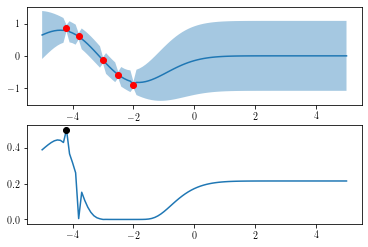

In [133]:
# we make up a covariance matrix, and invert it.
inv_cov_matrix = np.linalg.inv(makeCovMatrix(X_data,params))

y_means,y_stds = np.zeros(len(xs)), np.zeros(len(xs))
for i,x_query in enumerate(xs):
    mu, var = prediction(x_query, X_data, y_data, params)
    std = np.sqrt(var) + params['theta_noise']
    y_means[i], y_stds[i] = mu, std
    
# Plot the GP predictions, everywhere
plt.subplot(211)
plt.fill_between(xs,y_means+y_stds,y_means-y_stds,alpha=.4)
plt.plot(xs,y_means)
plt.plot(X_data, y_data, 'or') # the data points we've observed

# Find the Prob_of_Improvement, everywhere
y_best = max(y_data)
infill = infill_function(y_means,y_stds,y_best)

plt.subplot(212)
plt.plot(xs,infill)
index = np.argmax(infill)
plt.plot(xs[index],max(infill),'ok')

# Add to the data set
X_data = np.append(X_data,xs[index])
y_data = true_surface(X_data)